In [71]:
import numpy.random as npr
from scipy.special import digamma, polygamma

import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.experimental.ode import odeint
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
import jax.scipy.stats.norm as norm
import jax.scipy.stats.gamma as gamma

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_sample, init_to_median, init_to_value

import matplotlib.pyplot as plt
import pandas as pd

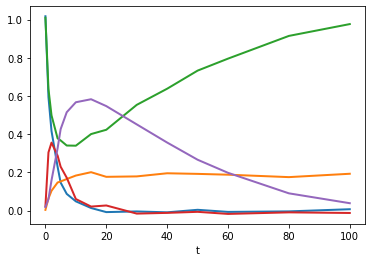

In [66]:
# Generate data 
def dstate_dt(state, t, params):
    """
    Protein transduction model.
    """
    p1, p2, p3, p4, p5, p6 = (
        params[..., 0],
        params[..., 1],
        params[..., 2],
        params[..., 3],
        params[..., 4],
        params[..., 5],
    )
    S = state[0]
    dS = state[1]
    R = state[2]
    Rs = state[3]
    Rpp = state[4]
    dstate = [-p1*S - p2*S*R + p3*R*S, 
              p1*S, 
              -p2*S*R + p3*Rs + p5*Rpp/(p6+Rpp),
             p2*S*R - p3*Rs - p4*Rs,
             p4*Rs - p5*Rpp/(p6+Rpp)]
    return jnp.stack(dstate)

init_rng = npr.RandomState(0)

t = [0., 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.]
true_params = jnp.array([0.07, 0.6, 0.05, 0.3, 0.017, 0.3])
init_state = [1.0, 0.0, 1.0, 0.0, 0.0]
sigma = 0.01

ode_solution = odeint(dstate_dt, jnp.array(init_state), jnp.array(t), true_params, rtol=1e-6, atol=1e-5, mxstep=1000)
yobs = ode_solution + sigma * init_rng.normal(size=(len(t),len(init_state)))

plt.plot(t, yobs, lw=2)
plt.xlabel('t')
plt.show()

In [69]:
def model(y=None):
    """
    :param numpy.ndarray y: measured populations with shape (15, 5)
    """
    # initial state
    state_init = jnp.array([1.0, 0., 1.0, 0., 0.])
    # measurement times
    t = jnp.array([0., 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100])
    # parameters p1-6 of dstate_dt
    theta = numpyro.sample(
        "theta",
        dist.Gamma(
            concentration=jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
            rate=jnp.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0]),
        ),
        #dist.Beta(
        #    concentration1=jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
        #    concentration0=jnp.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0]),
        #),
    )
    # integrate dstate/dt, the result will have shape 15 x 5
    state = odeint(dstate_dt, state_init, t[:-2], theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    # measurement errors
    sigma = 0.01
    # measured populations
    numpyro.sample("y", dist.Normal(state, sigma), obs=y[:-2])

In [70]:
num_warmup = 500
num_samples = 1000
num_chains = 1

#init_strategy = init_to_sample()
init_strategy = init_to_median(num_samples=10)
#init_strategy=init_to_value(values={"theta": jnp.array([0.07, 0.6, 0.05, 0.3, 0.017, 0.3])})

# use dense_mass for better mixing rate
mcmc = MCMC(
    #NUTS(model, init_strategy=init_strategy),
    NUTS(model, dense_mass=True, init_strategy=init_strategy, adapt_step_size=True),
    num_warmup,
    num_samples,
)
with numpyro.validation_enabled():
    result = mcmc.run(random.PRNGKey(1), y=yobs)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [01:07<00:00, 22.23it/s, 1023 steps of size 1.25e-03. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.37      0.29      0.27      0.07      0.78      2.39      3.17
  theta[1]      0.41      0.32      0.28      0.08      0.94      2.88      2.94
  theta[2]      0.03      0.03      0.02      0.00      0.08      2.51      2.61
  theta[3]      0.33      0.02      0.34      0.31      0.34      3.18      1.66
  theta[4]      0.13      0.06      0.16      0.04      0.19      2.48      2.67
  theta[5]      0.67      0.29      0.51      0.42      1.15      2.80      2.06

Number of divergences: 2


$$
\begin{align}
\phi &= \log \theta \\
\mu_\phi &= \mathbb{E}[\phi] = \mathbb{E}[\log \theta] = \psi(\alpha)-\log \beta \\
\Sigma_{\phi\phi} &= \textrm{var}(\phi) I = \psi^{(1)}(\alpha) I
\end{align}
$$

In [198]:
shp = 1.
rt = 2.
dim = 6
mu_phi = (digamma(shp)-jnp.log(rt))*jnp.ones(dim)
Sigma_phi = polygamma(1, shp) * jnp.eye(dim)

# Setup sigma points
alpha = 1e-1
kappa = 0.
beta = 2.
lbda = (dim+kappa)*alpha**2-dim
Sigma_sqrt = jnp.sqrt((dim+lbda)*polygamma(1,shp))* jnp.eye(dim)
sigma_points = []
weights_m = []
weights_c = []
sigma_points.append(mu_phi)
weights_m.append(lbda/(dim+lbda))
weights_c.append(lbda/(dim+lbda)+1.-alpha**2+beta)

for i in range(dim):
    weights_m.append(0.5/(dim+lbda))
    weights_m.append(0.5/(dim+lbda))
    weights_c.append(0.5/(dim+lbda))
    weights_c.append(0.5/(dim+lbda))
    sigma_points.append(mu_phi+Sigma_sqrt[i])
    sigma_points.append(mu_phi-Sigma_sqrt[i])
    
sigma_points = jnp.array(sigma_points)
weights_m = jnp.array(weights_m)
weights_c = jnp.array(weights_c)

print(jnp.dot(weights_m,sigma_points))

[-1.2703625 -1.2703625 -1.2703587 -1.2703625 -1.2703644 -1.270362 ]


In [199]:
# initial state
state_init = jnp.array([1.0, 0., 1.0, 0., 0.])
# measurement times
t = jnp.array([0., 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100])
# nl sigma ponts
nl_sigma_points = jnp.array([odeint(dstate_dt, state_init, t, jnp.exp(sigma_points[i]), rtol=1e-6, atol=1e-5, mxstep=1000) 
                             for i in range(2*dim+1)])

In [200]:
# compute mu_y
mu_y = jnp.average(nl_sigma_points, axis=0, weights=weights_m)
demeaned = (nl_sigma_points-mu_y).reshape((2*dim+1,len(t)*len(state_init)))
Sigma_yy = (sigma**2) * jnp.eye(len(t)*len(state_init)) + jnp.cov(demeaned.T, aweights=weights_c)


In [204]:
Sigma_yy

AttributeError: '_DeviceArray' object has no attribute 'det'

In [171]:
jnp.cov(demeaned.T, aweights=weights_c)

DeviceArray(0.0001549, dtype=float32)